In [2]:
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings(
    "ignore",
    category=NumbaWarning,
    message="Compilation requested for previously compiled argument types"
)
warnings.filterwarnings(
    "ignore",
    message="n_jobs value .* overridden to 1 by setting random_state",
    category=UserWarning
)

# Study Material: PCA, t-SNE, and UMAP Algorithms

## Table of Contents
1. [Principal Component Analysis (PCA)](#principal-component-analysis-pca)
2. [t-distributed Stochastic Neighbor Embedding (t-SNE)](#t-distributed-stochastic-neighbor-embedding-t-sne)
3. [Uniform Manifold Approximation and Projection (UMAP)](#uniform-manifold-approximation-and-projection-umap)
4. [Comparative Analysis](#comparative-analysis)

---

## Principal Component Analysis (PCA)

### Historical Background

Principal Component Analysis has its origins dating back to **1901** when **Karl Pearson** first introduced the concept in his groundbreaking paper titled "On Lines and Planes of Closest Fit to Systems of Points in Space." Pearson's work laid the foundation for what would become one of the most fundamental techniques in multivariate statistics and data analysis.

The technique was later independently developed and formalized by **Harold Hotelling** in the **1930s**, who expanded upon Pearson's work and provided the mathematical framework that we recognize today. This is why PCA is sometimes referred to as the "Hotelling transform" in quality control applications.

### Mathematical Intuition

PCA can be conceptualized as **fitting a p-dimensional ellipsoid to the data**, where each axis of the ellipsoid represents a principal component. The core intuition behind PCA is to find a new coordinate system that optimally describes the variance in the data:

1. **Variance Maximization**: The first principal component is the direction in which the data varies the most
2. **Orthogonality**: Each subsequent component is orthogonal to all previous components
3. **Dimensionality Reduction**: Components with small variance can be discarded to reduce dimensionality

Mathematically, PCA works by:
- Computing the covariance matrix of the centered data
- Finding eigenvalues and eigenvectors of this covariance matrix
- The eigenvectors become the principal components
- The eigenvalues represent the variance explained by each component

### Main Hyperparameters
- **n_components:** Number of principal components kept 
- **svd_solver:** Algorithm used for SVD decomposition 
- **whiten:** Scales components to unit variance

#### Effect of Hyperparameters
- **n_components:** 
    - Controls information retention and noise reduction.
    - Typically, "explained variance" threshold (e.g. 80% or 95%) is used to pick the number of components that capture most variance. Fewer components discard more noise but may lose signal; too many keep noise and increase complexity. Scree plots and permutation tests can systematically inform this choice[153][154].
- **svd_solver:** 
    - Affects speed/accuracy on large datasets. 'auto' and 'randomized' are best for most high-dimensional modern data. Not a major factor for interpretability.
- **whiten:** 
    - Sets PC variance to 1. Useful before feeding PCA output into other ML algorithms, but can obscure intuitive meaning.

#### Practical tip
- Always standardize (mean=0, std=1) your data before PCA.

### Python Implementation

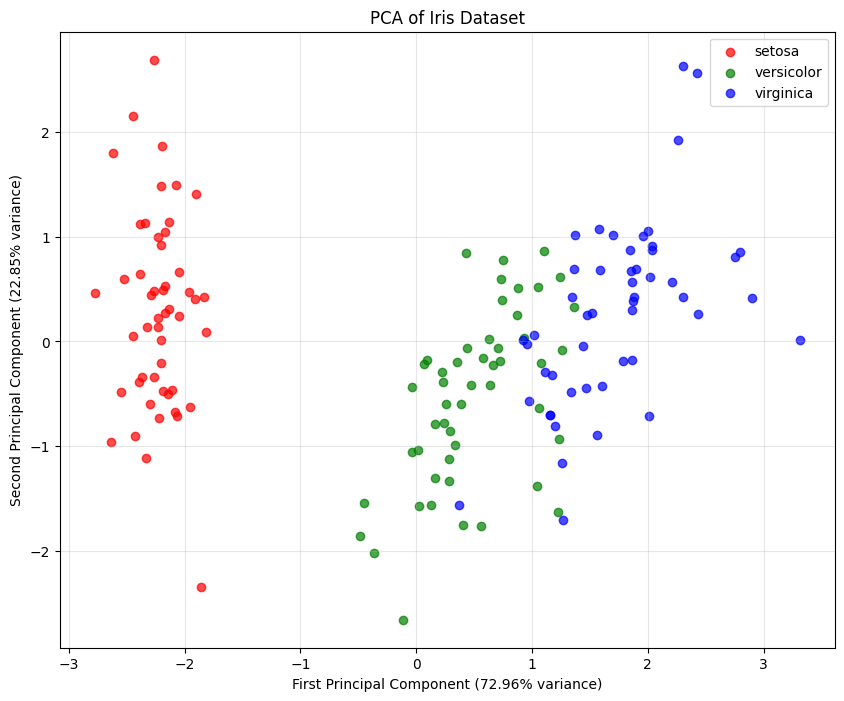

Explained variance ratio: [0.72962445 0.22850762]
Cumulative explained variance: [0.72962445 0.95813207]

Principal Components:
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load sample data
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], 
                c=colors[i], label=iris.target_names[i], alpha=0.7)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Iris Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

# Access the principal components (loadings)
feature_names = iris.feature_names
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)
print("\nPrincipal Components:")
print(components_df)

---

## t-distributed Stochastic Neighbor Embedding (t-SNE)

### Historical Background

t-SNE was developed by **Laurens van der Maaten** and **Geoffrey Hinton** in **2008**. The technique evolved from the earlier Stochastic Neighbor Embedding (SNE) algorithm, addressing several key limitations:

1. **Optimization Difficulties**: SNE had a cost function that was very difficult to optimize
2. **Crowding Problem**: SNE struggled to represent high-dimensional data in lower dimensions without points becoming too crowded

The key innovations of t-SNE over SNE were:
- **Symmetrization**: Making the probability distributions symmetric
- **t-distribution**: Using Student's t-distribution for low-dimensional space instead of Gaussian

### Mathematical Intuition

t-SNE operates in two main stages:

1. **High-dimensional Probability Distribution**: Creates a probability distribution over pairs of data points such that similar objects are assigned higher probability
2. **Low-dimensional Mapping**: Defines a similar probability distribution in the low-dimensional map and minimizes the Kullback-Leibler divergence between the two distributions

The algorithm's intuition can be understood as:
- In high-dimensional space: Use Gaussian distributions to model similarities
- In low-dimensional space: Use t-distribution to avoid crowding
- Optimize: Minimize the difference between these probability distributions

### Main Hyperparameters
- **perplexity:** (Neighborhood size parameter)
- **learning_rate (epsilon):** Step size in optimization
- **n_iter:** Number of optimization iterations
- **early_exaggeration:** Cluster separation strength at start

#### Effect of Hyperparameters
- **perplexity:**
    - Determines neighborhood size; low (5–30) for tight local grouping, high (>50) uncovers more global structure. Set based on dataset size (no more than N/3, usually in [5, 50]), and analyze different runs. Too low = fragmented small clusters; too high = merging/fading of clusters[131][36][128][152].
- **learning_rate:**
    - Default ('auto') works for most. Low: points become compressed; high: excessive scatter or positioning errors. Try in [100, 1000]; inspect sensitivity[152].
- **n_iter:**
    - Too low: poorly separated clusters. Typical: 250–1000 iterations, or until embedding visually stabilizes[152].
- **early_exaggeration:**
    - Larger exaggerates gaps between clusters, small blurs. Try default and adjust only if separation looks poor.

#### Practical tip
- Repeat t-SNE with multiple seeds/hyperparameters to verify robustness. Visual outcomes can change substantially by parameter values.

### Python Implementation

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 6.881306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.517685
[t-SNE] KL divergence after 1000 iterations: 1.310013


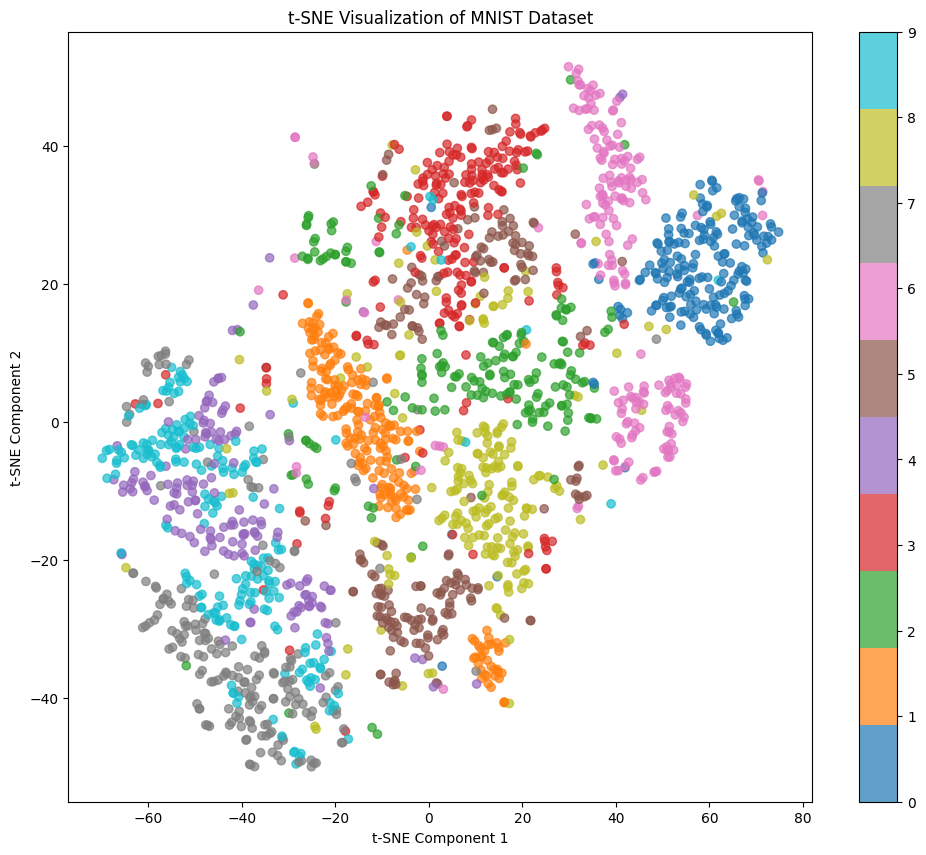

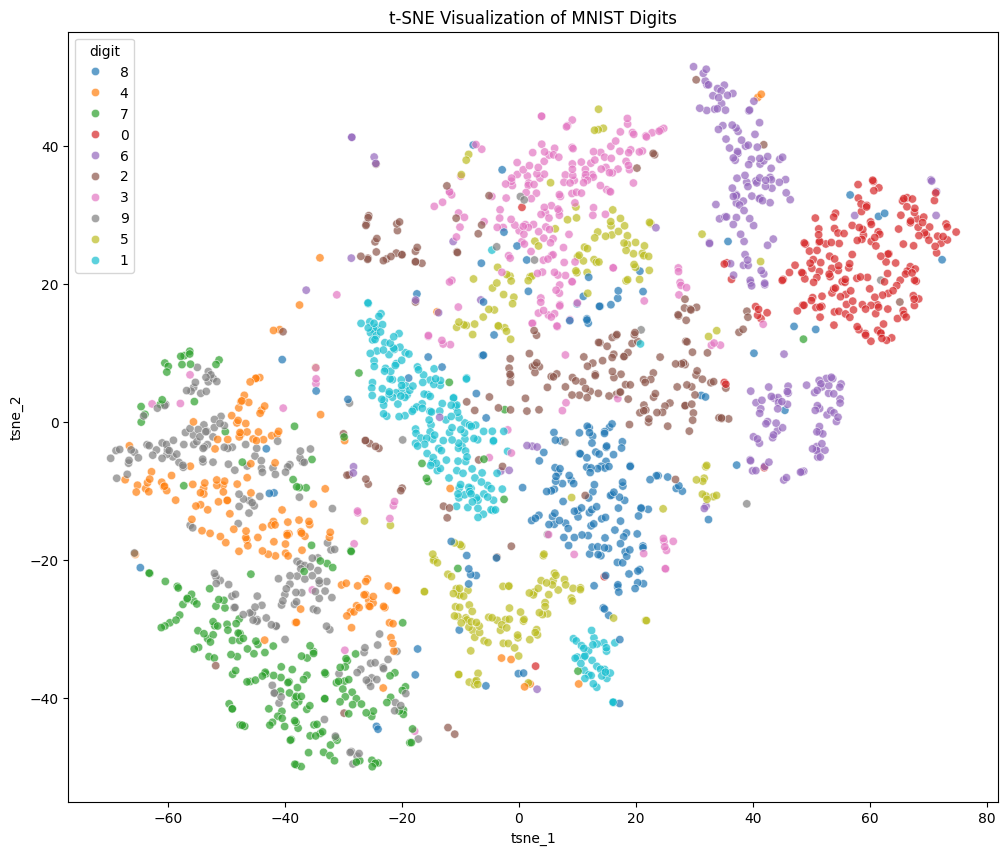

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load MNIST dataset (subset for demonstration)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Select a subset for faster computation
np.random.seed(42)
subset_indices = np.random.choice(X.shape[0], 2000, replace=False)
X_subset = X[subset_indices]
y_subset = y[subset_indices]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

# Apply t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    verbose=1
)

X_tsne = tsne.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=y_subset.astype(int), cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Alternative visualization with seaborn
tsne_df = pd.DataFrame({
    'tsne_1': X_tsne[:, 0],
    'tsne_2': X_tsne[:, 1],
    'digit': y_subset.astype(str)
})

plt.figure(figsize=(12, 10))
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2', hue='digit', alpha=0.7)
plt.title('t-SNE Visualization of MNIST Digits')
plt.show()

---

## Uniform Manifold Approximation and Projection (UMAP)

### Historical Background

UMAP was developed by **Leland McInnes**, **John Healy**, and **James Melville** in **2018**. It was created to address several limitations of existing dimensionality reduction techniques, particularly t-SNE:

1. **Scalability**: t-SNE doesn't scale well to very large datasets
2. **Global Structure**: t-SNE tends to lose global structure in favor of local structure
3. **Speed**: t-SNE can be computationally expensive for large datasets
4. **Determinism**: t-SNE results can be quite random between runs

UMAP is based on **Riemannian geometry** and **algebraic topology**, providing a more principled mathematical foundation compared to t-SNE.

### Mathematical Intuition

UMAP operates under several key principles:

1. **Manifold Assumption**: Data is uniformly distributed on a Riemannian manifold
2. **Local Connectivity**: Data points have local neighborhoods that can be approximated
3. **Fuzzy Topology**: Uses fuzzy set theory to handle uncertainty in topology

The algorithm works by:
- Constructing a high-dimensional graph representation of the data
- Creating a low-dimensional equivalent of this graph
- Optimizing the low-dimensional representation to match the high-dimensional structure

Key advantages over t-SNE:
- **Better Global Structure Preservation**
- **Faster Computation**
- **More Consistent Results**
- **Better Scalability**

### Main Hyperparameters
- **n_neighbors:** Balance between local and global structure
- **min_dist:** Minimum allowed inter-point distance (tightness)
- **n_components:** Output dimension (usually 2 or 3)
- **metric:** Distance function (Euclidean by default, can choose others)

#### Effect of Hyperparameters
- **n_neighbors:**
    - Lower values (2–10) provide sharper small clusters, high values (50–200) preserve broader relations but may blur details. Default is 15. Larger = more global.[123][121]
- **min_dist:**
    - Lower (0.0–0.1) yields denser, tighter clusters; higher (0.3–0.99) allows more separation between points, emphasizing global topological relationships. Default is 0.1. Tuning min_dist is crucial for cluster visualization[123][121].
- **n_components:**
    - Usually kept at 2 or 3 for visualization; can be higher for ML pipelines, where it impacts expressiveness.
- **metric:**
    - Changing metric changes similarity measure and can extract different data manifolds. Useful for non-Euclidean data.

#### Practical tip
- For visual clarity, start with default (n_neighbors=15, min_dist=0.1), then tune min_dist downward to enhance cluster tightness or upward for more even spread. For exploratory data analysis, test reasonable ranges ([121][123]).

### Python Implementation

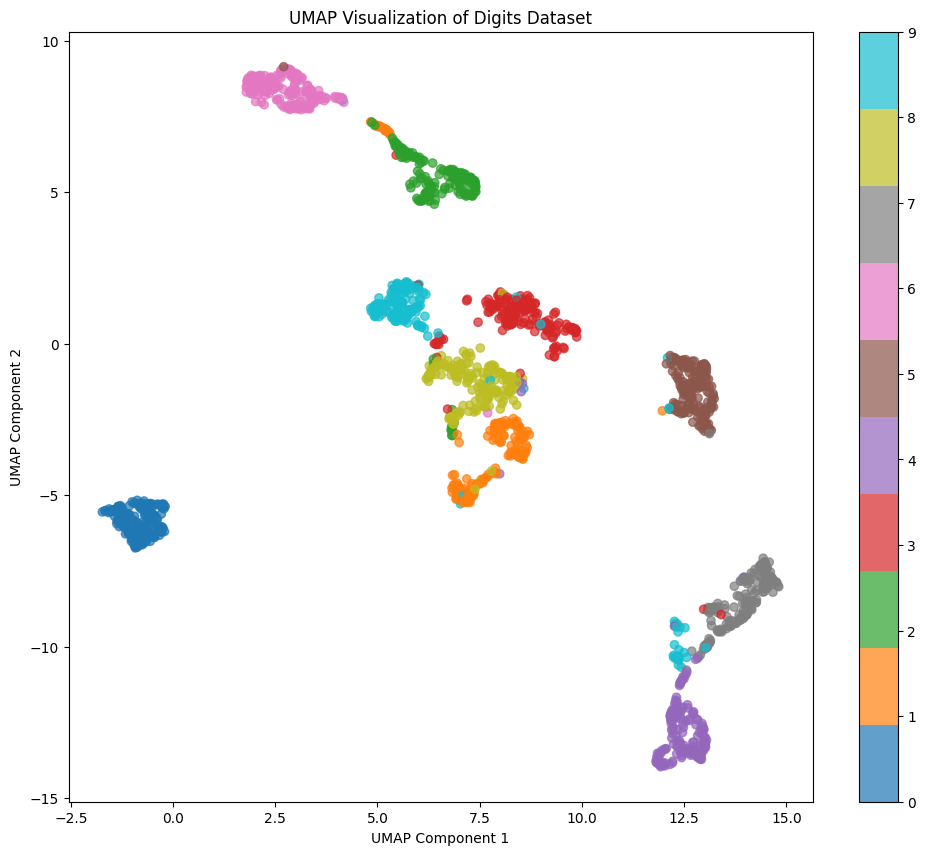

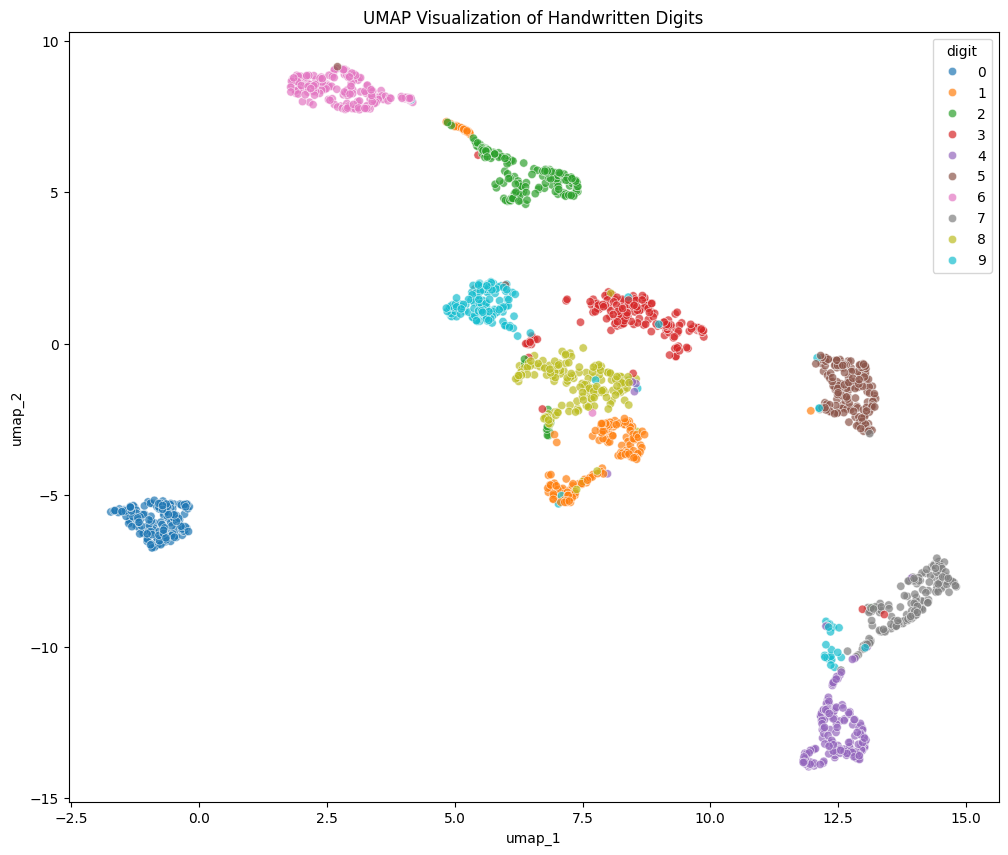

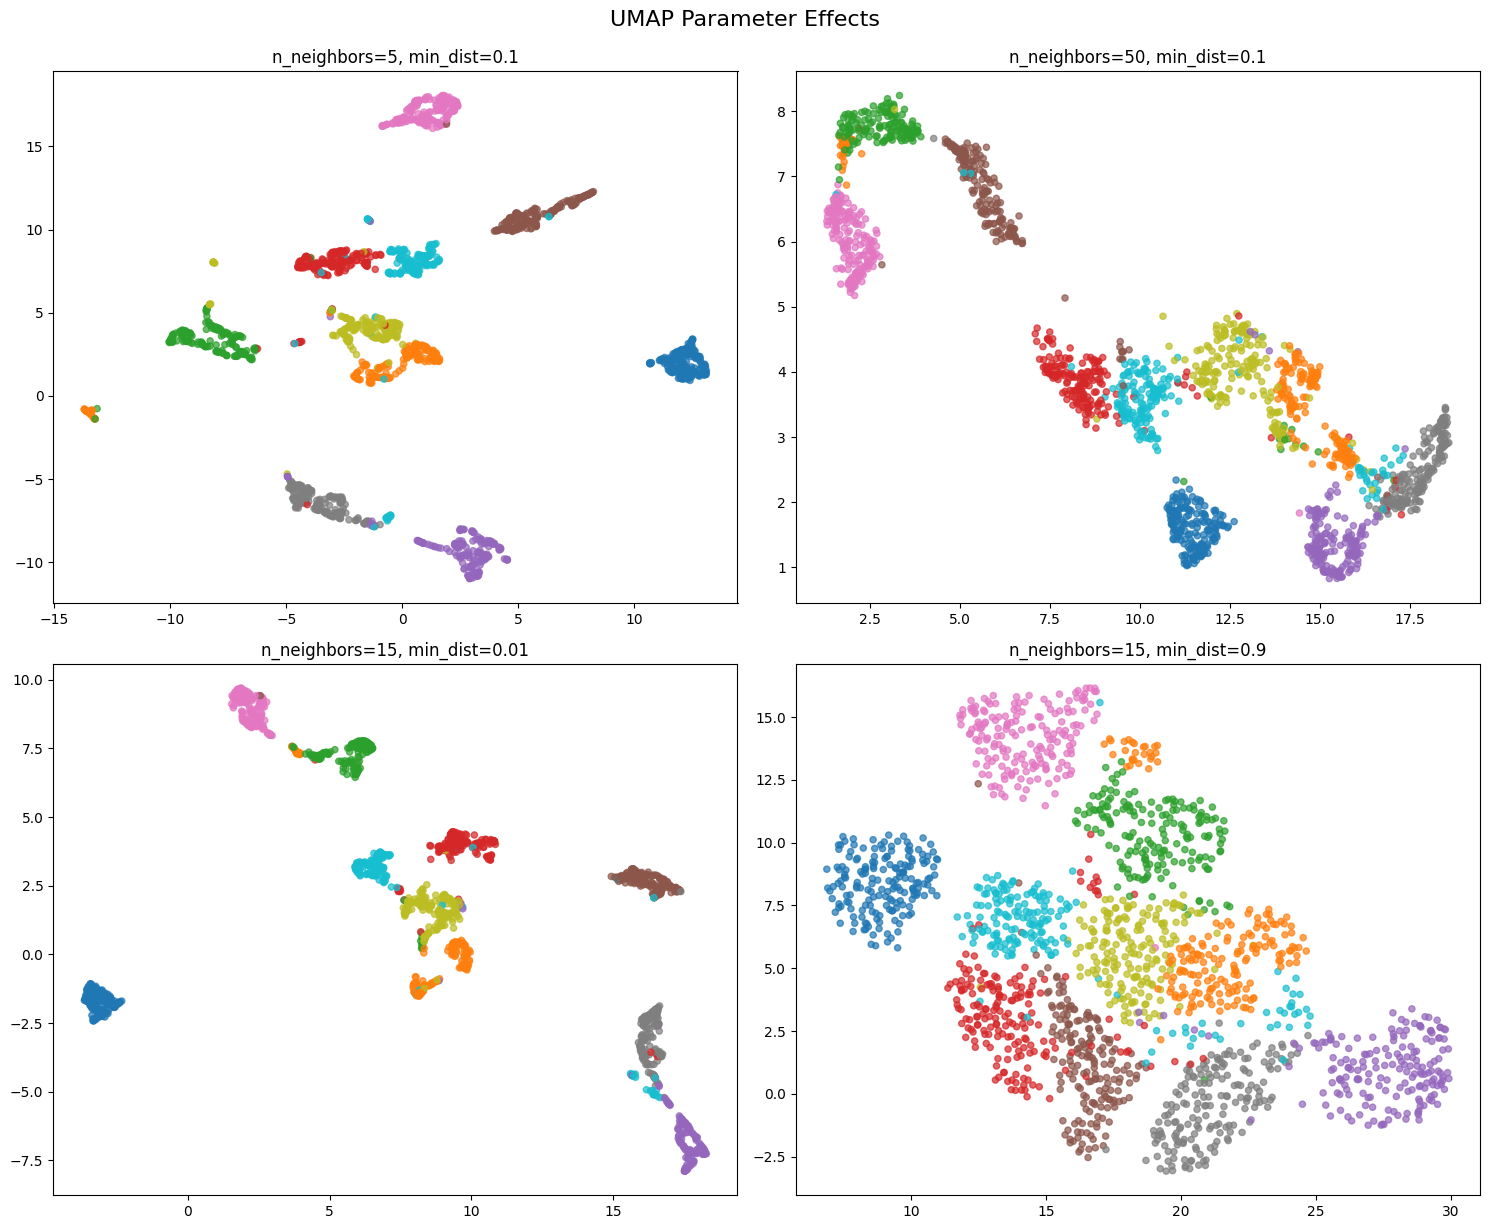

Timing Comparison:
------------------------------
UMAP: 3.76 seconds
t-SNE: 3.38 seconds


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from umap import UMAP
import umap.plot
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    n_jobs=1
)

X_umap = umap_model.fit_transform(X_scaled)

# Create basic visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                     c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('UMAP Visualization of Digits Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# Enhanced visualization with seaborn
umap_df = pd.DataFrame({
    'umap_1': X_umap[:, 0],
    'umap_2': X_umap[:, 1],
    'digit': y.astype(str)
})

plt.figure(figsize=(12, 10))
sns.scatterplot(data=umap_df, x='umap_1', y='umap_2', hue='digit', alpha=0.7)
plt.title('UMAP Visualization of Handwritten Digits')
plt.show()

# Parameter exploration
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
parameters = [
    {'n_neighbors': 5, 'min_dist': 0.1},
    {'n_neighbors': 50, 'min_dist': 0.1},
    {'n_neighbors': 15, 'min_dist': 0.01},
    {'n_neighbors': 15, 'min_dist': 0.9}
]

for idx, params in enumerate(parameters):
    ax = axes[idx // 2, idx % 2]
    
    umap_temp = umap.UMAP(random_state=42, **params)
    X_temp = umap_temp.fit_transform(X_scaled)
    
    scatter = ax.scatter(X_temp[:, 0], X_temp[:, 1], 
                        c=y, cmap='tab10', alpha=0.7, s=20)
    ax.set_title(f"n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")

plt.tight_layout()
plt.suptitle('UMAP Parameter Effects', y=1.02, fontsize=16)
plt.show()

# Compare processing times (for information)
import time

print("Timing Comparison:")
print("-" * 30)

# UMAP timing
start_time = time.time()
umap_result = umap.UMAP(n_components=2, random_state=42, n_jobs=1).fit_transform(X_scaled)
umap_time = time.time() - start_time
print(f"UMAP: {umap_time:.2f} seconds")

# t-SNE timing (for comparison)
from sklearn.manifold import TSNE
start_time = time.time()
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
tsne_time = time.time() - start_time
print(f"t-SNE: {tsne_time:.2f} seconds")

---

## Comparative Analysis

### When to Use Each Algorithm

| Algorithm | Best Use Cases | Strengths | Limitations |
|-----------|---------------|-----------|-------------|
| **PCA** | - Initial data exploration<br>- Feature reduction<br>- Noise reduction<br>- Linear relationships | - Fast and deterministic<br>- Interpretable components<br>- Good for linear relationships<br>- Memory efficient | - Only captures linear relationships<br>- May not preserve local structure<br>- Less effective for complex manifolds |
| **t-SNE** | - Data visualization<br>- Cluster analysis<br>- Exploratory analysis<br>- Non-linear manifolds | - Excellent local structure preservation<br>- Great for visualization<br>- Reveals clusters well<br>- Handles non-linear relationships | - Computationally expensive<br>- Can lose global structure<br>- Non-deterministic<br>- Difficult to interpret axes |
| **UMAP** | - Large datasets<br>- Preserving global structure<br>- General-purpose reduction<br>- Machine learning pipelines | - Fast and scalable<br>- Preserves both local and global structure<br>- More deterministic than t-SNE<br>- Good for downstream tasks | - More complex parameter tuning<br>- Newer technique (less established)<br>- Can be sensitive to hyperparameters |

### Performance Characteristics

PCA: 0.002 seconds
t-SNE: 2.012 seconds
UMAP: 1.465 seconds


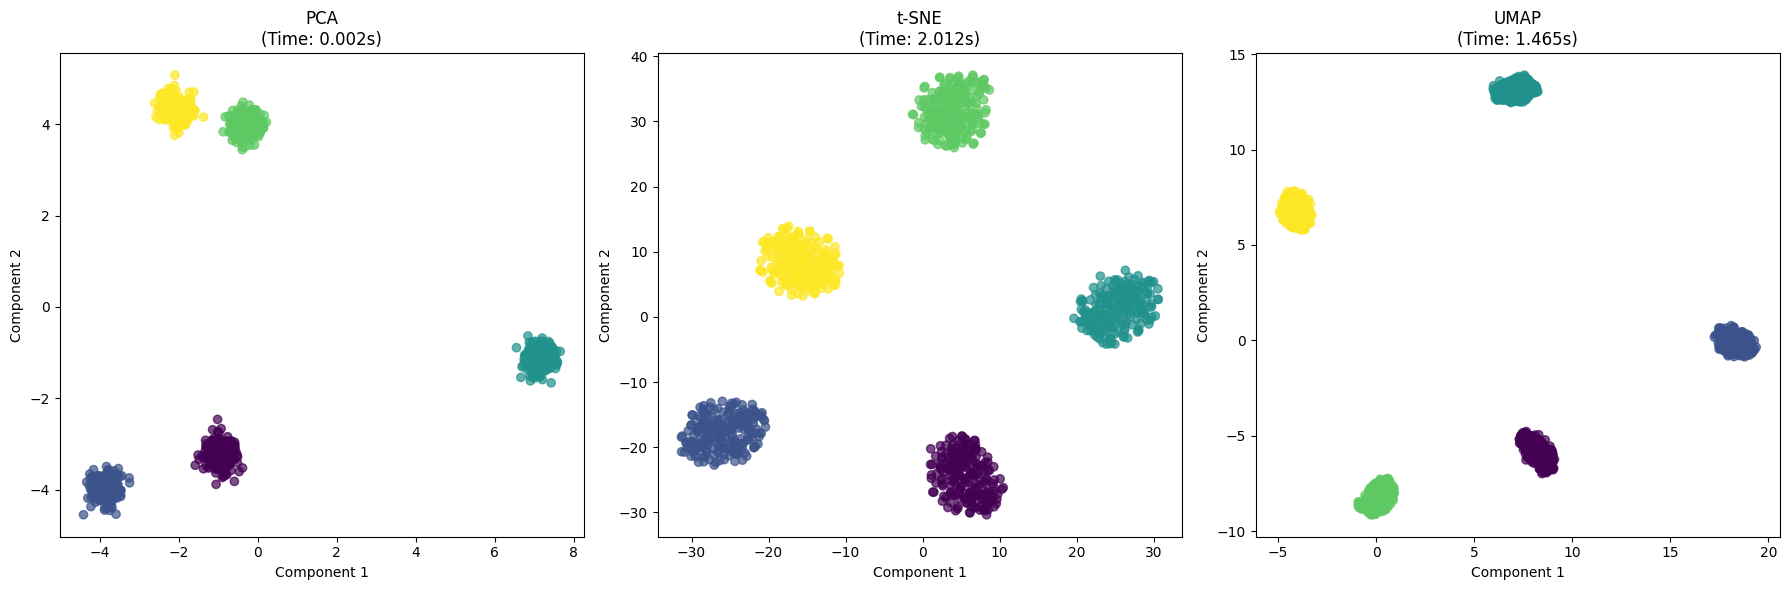

In [6]:
# Comprehensive comparison example
import time
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Generate sample data
X, y = make_blobs(n_samples=1000, centers=5, n_features=50, 
                  cluster_std=1.0, random_state=42)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compare algorithms
algorithms = {
    'PCA': PCA(n_components=2),
    't-SNE': TSNE(n_components=2, random_state=42),
    'UMAP': umap.UMAP(n_components=2, random_state=42)
}

results = {}
times = {}

for name, algorithm in algorithms.items():
    start_time = time.time()
    
    if name == 'PCA':
        result = algorithm.fit_transform(X_scaled)
    else:
        result = algorithm.fit_transform(X_scaled)
    
    end_time = time.time()
    
    results[name] = result
    times[name] = end_time - start_time
    
    print(f"{name}: {times[name]:.3f} seconds")

# Visualization comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    scatter = ax.scatter(result[:, 0], result[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax.set_title(f'{name}\n(Time: {times[name]:.3f}s)')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

plt.tight_layout()
plt.show()

### Key Takeaways

1. **PCA** is the go-to choice for:
   - Quick exploratory analysis
   - Linear dimensionality reduction
   - When interpretability is crucial
   - Preprocessing for other algorithms

2. **t-SNE** excels at:
   - Visualizing complex, non-linear data structures
   - Revealing hidden clusters
   - Exploratory data analysis of small to medium datasets

3. **UMAP** is ideal for:
   - Large-scale dimensionality reduction
   - Preserving both local and global structure
   - When you need consistent, reproducible results
   - As a preprocessing step for machine learning

### Practical Tips

- **Always standardize your data** before applying any of these algorithms
- **Start with PCA** to get a baseline understanding of your data
- **Use t-SNE for visualization** when you suspect non-linear relationships
- **Choose UMAP for production systems** where consistency and speed matter
- **Experiment with hyperparameters** - they significantly impact results
- **Consider the downstream task** - some algorithms work better as preprocessing for specific tasks

This study material provides a comprehensive foundation for understanding and implementing these three fundamental dimensionality reduction techniques in your data science workflow.

### Hyperparameters and Their Effect


| Algorithm | Key Hyperparameters                  | Effect                                                   |
|-----------|--------------------------------------|----------------------------------------------------------|
| **PCA**       | n_components                        | Info retained/noise removed (via explained variance)     |
|           | svd_solver, whiten                   | Speed, scaling, and interpretability                     |
| **t-SNE**     | perplexity, learning_rate, n_iter    | Local v/s global, separation, convergence                |
|           | early_exaggeration                   | Cluster separation at early iterations                   |
| **UMAP**      | n_neighbors, min_dist                | Local v/s global, cluster compactness                    |
|           | n_components, metric                 | Output dimension, manifold structure preservation        |

(For full tuning strategies, see references and official library docs)